# Практическое задание №8 по теме "Проверяем работу модели на практике: A/B-тестирование".

## Из видеоурока

1. Скачать датасет: https://drive.google.com/file/d/1MpWBFIbqu4mbiD0BBKYX6YhS-f4mN3Z_
2. Проверить гипотезу о том, в каком варианте теста (control/personalization) больше конверсия (converted)
3. Проверить значимо ли это отличие статистически

In [1]:
import pandas as pd
import numpy as np
from statsmodels.stats import proportion
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
marketing_campaign = pd.read_csv("marketing_campaign.csv")
marketing_campaign.head(3)

,user_id,date_served,marketing_channel,variant,language_displayed,converted
0,a1000,1/1/18,House Ads,personalization,English,True
1,a1001,1/1/18,House Ads,personalization,English,True
2,a1002,1/1/18,House Ads,personalization,English,True


In [3]:
marketing_campaign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10037 entries, 0 to 10036
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             10037 non-null  object
 1   date_served         10021 non-null  object
 2   marketing_channel   10022 non-null  object
 3   variant             10037 non-null  object
 4   language_displayed  10037 non-null  object
 5   converted           10022 non-null  object
dtypes: object(6)
memory usage: 470.6+ KB


Как видим есть в наших данных пропуски.

Нас интересует признак converted и признак variant. Остальные признаки нас не интересуют. Посмотрим соотношение данных и пропуски в этих столбцах.

In [4]:
marketing_campaign.variant.value_counts()

control            5091
personalization    4946
Name: variant, dtype: int64

Соотношение в целом 50 на 50

In [5]:
marketing_campaign.converted.value_counts()

False    8946
True     1076
Name: converted, dtype: int64

Соотношение 10 на 90.

In [6]:
marketing_campaign.loc[marketing_campaign['converted'].isnull(), ['variant', 'converted']]

,variant,converted
9944,control,NaN
9945,control,NaN
9946,control,NaN
9947,control,NaN
9948,control,NaN
9949,control,NaN
9950,control,NaN
9951,control,NaN
9952,control,NaN
9953,control,NaN


Пропуски как мы видим есть только в контрольной группе. Так как количество объектов в контрольной больше чем в персонализированной, то можно просто откинуть Nan объекты.

In [7]:
marketing_campaign = marketing_campaign.dropna(subset=['converted'])

По заданию нужно понять, а что же лучше, группа контрольная (А) или группа персонализированная (B)? Нужно понять где больше конверсия и понять являются ли различия в конверсии статистически значимымми

Выборки: $X_{1}^{n_1}$ - контрольная, $X_{2}^{n_2}$ - персонализированная.

Метрика: доля (конверсия), $p$

Гипотезы: 

Нулевая гипотеза $H_0$: $p_1 = p_2$ (конверсии совпадают)

Альтернативная гипотеза $H_1$: $p_1 \neq p_2$ (конверсии разные)

Статистический критерий: 
1. Z-критерий Фишера
2. Критерий ХИ-квадрат

Уровень значимости $\alpha$: 0.05

converted: конверсия в покупку, 1 - пользователь совершил покупку, 0 - нет

In [8]:
z_crit_value = 1.96 # соответствует доверительному интервалу в 95%
k1 = (marketing_campaign[marketing_campaign['converted']==True]['variant'] == 'control').sum()
n1 = marketing_campaign[marketing_campaign['variant'] == 'control'].shape[0]
k2 = (marketing_campaign[marketing_campaign['converted']==True]['variant'] == 'personalization').sum()
n2 = marketing_campaign[marketing_campaign['variant'] == 'personalization'].shape[0]

k1, n1, k2, n2

(371, 5076, 705, 4946)

In [9]:
grouped = marketing_campaign.pivot_table(values='converted', index='variant', aggfunc=['sum', 'count'])
grouped

,sum,count
,converted,converted
variant,,
control,371,5076
personalization,705,4946


Расчитываем конверсии для контрольной и персонализированной групп:

In [10]:
p1, p2 = k1/n1, k2/n2
print(f"Конверсия А: {p1:.3f}; Конверсия B: {p2:.3f}")
if p1 > p2:
    print("A > B")
elif p1 == p2:
    print("A = B")
else:
    print("A < B")

Конверсия А: 0.073; Конверсия B: 0.143
A < B


Как видим конверсия контрольной группы А ниже чем у персонализированной группы B (которой показывали специальную рекламу). Теперь нужно проверить статистически и убедиться, что полученный результат неслучайный и статистически значимый.

Статистический тест с помощью z-критерия Фишера

In [11]:
z_score, z_pvalue = proportion.proportions_ztest(np.array([k1, k2]), np.array([n1, n2]))
print(f'Results are z_score={z_score:.3f} pvalue={z_pvalue:.3f}')

Results are z_score=-11.228 pvalue=0.000


Статистический тест с помощью критерия хи-квадрат

In [12]:
chisq, pvalue, table = proportion.proportions_chisquare(np.array([k1, k2]), np.array([n1, n2]))
print(f'Results are chisq={chisq:.3f} pvalue={pvalue:.3f}')

Results are chisq=126.078 pvalue=0.000


**Вывод:** 

В обоих статистических тестах $pvalue=0$, это означает, что мы смело отвергаем нулевую гипотезу. Различие имеет статистическую значимость. Конверсия для персонализированный группы выше чем для контрольной группы и это отличие является статистически значимым.

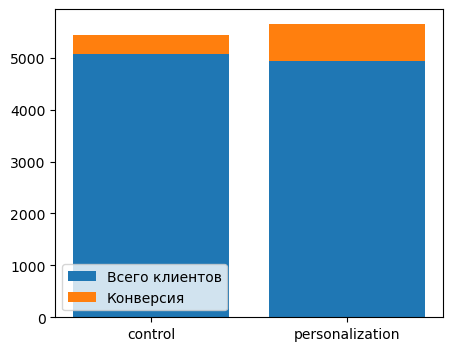

In [13]:
plt.figure(figsize=(5, 4))
plt.bar([1, 2], grouped['count']['converted'], label='Всего клиентов')
plt.bar([1, 2], grouped['sum']['converted'], bottom=grouped['count']['converted'], label='Конверcия')
plt.xticks([1, 2], ['control', 'personalization'])
plt.legend();

## Из методички

#### 1. Если мы рассчитали 95% доверительный интервал для среднего значения, то какие из следующих утверждений являются верными?

Выберите несколько вариантов и попытайтесь объяснить свой выбор:

1) Если многократно повторять эксперимент, то 95 % выборочных средних значений будут принадлежать рассчитанному нами доверительному интервалу.

2) Мы можем быть на 95% уверены, что среднее значение в генеральной совокупности принадлежит рассчитанному доверительному интервалу.

3) Если многократно повторять эксперимент, для каждой выборки рассчитывать свой доверительный интервал, то в 95 % случаев истинное среднее будет находиться внутри доверительного интервала.

4) Среднее значение в генеральной совокупности точно превышает нижнюю границу 95% доверительного интервала.

5) Среднее значение в генеральной совокупности точно принадлежит рассчитанному доверительному интервалу.

**Ответ:** 2, 3

4 и 5 вариант можно сразу исключить поскольку утверждения строгие. Среднее значение в генеральной совокупности может и не превышать нижнюю границу 95% доверительного интервала, а также может и не принадлежать рассчитанному доверительному интервалу.

Вариант 1. По условию мы рассчитали 95% доверительный интервал для некой выборочной средней. У нас спрашивают, попадут ли в этот интервал 95% всех выборочных средних. Собственно мы говорим о выборочных средних, а они могут быть какими угодно и нет никакой гарантии, что 95% этих выборочных средних попадут в расчитанный доверительный интервал какого-то выборочного среднего.

Однако, можно смело утверждать, что мы можем быть на 95% уверены, что среднее значение в генеральной совокупности будет принадлежать расчитанному доверительному интервалу. Ведь доверительным называют интервал, который покрывает неизвестный параметр с заданной надёжностью (в нашем случае среднее значение в генеральной совокупности - неизвестный параметр).
То есть вариант 2 подходит. 

Вариант 3 очень похож на 2, в нем также расчитывается доверительный интервал для каждой выборки. Как и в пункте 2 истинное значение среднего в генеральной совокупности будет находиться внутри доверительного интервала в 95% случаях.

#### 2. Если мы увеличиваем объем выборки в два раза (при условии, что показатель стандартного отклонения остается неизменным), то 95% доверительный интервал

Выберите один вариант из списка

1) стал более узким
2) возможны оба варианта
3) стал более широким

**Ответ:** 1

Среднеквадратичное отклонение (стандартная ошибка) среднего:
$$se = \frac{sd}{\sqrt{n}}$$

Стандартное отклонение не изменилось, а вот размер выборки увеличился в 2 раза. Получается, что с ростом выборки, уменьшается значение среднеквадратичного отклонения среднего. Ошибка меньше, интервал сужается.

#### 3. В центре 95% доверительного интервала, рассчитанного по выборочным значениям, находится:

Выберите один вариант из списка

1) Значение стандартной ошибки среднего
2) Выборочное среднее значение
3) Среднее значение генеральной совокупности

**Ответ:** 2

#### 4. Часто на практике нулевая гипотеза отклоняется, и различия считаются статистически достоверными, если p < 0,05. Однако часто в статистике используется более жесткий критерий достоверности различий, например, при условии, что p < 0,01. Значение p-уровня значимости, которое выбирается, в качестве порога обозначается буквой α (альфа). Например, если исследователь решил, что α = 0,05, то и нулевая гипотеза будет отклоняться при условии, что p < 0,05. 

#### Если в определенной ситуации весьма рискованно отклонить нулевую гипотезу, когда она на самом деле верна, то лучше использовать показатель α равный 

Выберите один вариант из списка

1) 0,1
2) 0,001
3) 0,05
4) 0,5

**Ответ:** 2

#### 5. Данные некоторого исследования сообщают нам, что средний рост детей в 14 лет составляет 166 сантиметров. Однако это лишь выборочная оценка, и исследователи рассчитали 95% доверительный интервал, который составил [160, 172]. Укажите верные утверждения:

Выберите несколько вариантов и попытайтесь объяснить свой выбор:

1) У нас достаточно оснований отклонить нулевую гипотезу, что среднее в генеральной совокупности равняется 173
2) Вероятность того, что истинное среднее значение больше 172, составляет 0,01
3) У нас достаточно оснований отклонить нулевую гипотезу, что среднее в генеральной совокупности равняется 158.
4) Доверительный интервал не может иметь такие границы, т. к. выборочное стандартное отклонение равняется 10, следовательно доверительный интервал должен быть значительно шире.

**Ответ:** 1, 3 

Вариант 1. Значение не попало в доверительный интервал - гипотеза отклоняется.<br>
Вариант 2. Не факт, что это именно 0,01. Нужен расчет.<br>
Вариант 3. Верно, значение выходит за пределы доверительного интервала.<br>
Вариант 4. На размер доверительного интервала влияет также, например, размер выборки. Неверно.

#### 6. Предположим, нулевой гипотезой вашего исследования являлось предположение, что конверсия в генеральной совокупности равняется 0.4. Вы получили p = 0,12 и не смогли отклонить нулевую гипотезу. Однако позже выяснилось, что конверсия в генеральной совокупности действиетльно равна 0.4. Как можно оценить результаты?


Какой вариант корректный по вашему мнению и почему?
1) Вы не совершали ни ошибку первого рода, ни ошибку второго рода.
2) Вы совершили ошибку первого рода
3) Вы совершили ошибку второго рода

**Ответ:** 1

Ошибка первого рода - когда нулевая гипотеза отвергается, хотя на самом деле она верна! 

Ошибка второго рода - когда нулевая гипотеза принимается, хотя на самом деле она неверна! 

Нулевую гипотезу мы не отвергли, но при этом она верна. Ошибки первого рода и второго рода нет.

---